## This is the part that uses JAX

In [98]:
import jax.numpy as jnp

from jax import jit

from jax import lax
import jax
from jax import make_jaxpr
from jax import random
from jax import device_put

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

import cProfile
import pstats


data_type = complex

@jit
def division(x):  
    return jnp.where(x == 0, 0., 1 / x)
@jit
def Entropy(v):
  return -jnp.sum(jnp.where(v == 0, 0., jnp.log(v))*v)


@jit
def i_trunc_opt(Fs,d=2):
  chi = 20
  S,V,D = jnp.linalg.svd(Fs)
  VI = jax.lax.dynamic_slice(V, (0,), (chi,))  
  lam = VI/jnp.linalg.norm(VI)

  A = jax.lax.dynamic_slice(S, (0,0), (chi*d,chi))  
  A = A.reshape(chi,d,chi)
  
  B = jax.lax.dynamic_slice(D, (0,0), (chi,chi*d))  
  B = B.reshape(chi,d,chi)
  
  return A,lam,B

@jit
def Pauli_jaxed():
  S_z = jnp.array([[1.,0.],[0.,-1.]],dtype = complex)
  S_x = jnp.array([[0.,1.],[1.,0.]] ,dtype = complex)
  S_y = jnp.array([[0.,complex(0,-1.)],[complex(0,1.),0.]],dtype = complex) #Pauli Matrices
  S1 = {
     "x" : S_x,
     "xx": S_x, 
     "y" : S_y,
     "yy": S_y, 
     "z" : S_z,
     "zz": S_z }
  return S_z, S_x, S_y, S1

@jit
def Model_coefficients_jaxed(J_xx,J_yy,J_zz,h_x,h_y,h_z):
  Interactions = {
                  "xx":J_xx,
                  "yy":J_yy,
                  "zz":J_zz}
  Fields = {
          "x":h_x,  #Fields
          "y":h_y,
          "z":h_z}
  return Interactions,Fields

def Create_HamiltonianTEBD(Model, S1, Interactions, Fields,d):
    H = jnp.zeros((d,d,d,d)).astype(complex)

    for j in range(len(Model[0])):
      H += jnp.einsum("ij,kl->ikjl",2*Interactions[Model[0][j]]*S1[Model[0][j]],S1[Model[0][j]]) #two-site

    for k in range(len(Model[1])):
      H += jnp.einsum("ij,kl->ikjl",Fields[Model[1][k]]*S1[Model[1][k]],jnp.diag(np.ones(2)))    #on-site
      H += jnp.einsum("ij,kl->ikjl",jnp.diag(np.ones(2)),Fields[Model[1][k]]*S1[Model[1][k]])
    return H


@jit
def Compute_Theta_optimized(lam_0,Gamma_0,lam_1,Gamma_1):
    Theta=jnp.tensordot(jnp.diag(lam_1),Gamma_0,axes = 1)
    Theta=jnp.tensordot(Theta,jnp.diag(lam_1),axes = 1)
    Theta=jnp.einsum("aib,bjc->aijc",Theta,Gamma_1)
    Theta=jnp.tensordot(Theta,jnp.diag(lam_0),axes = 1)

    return Theta

# tazi funckiq e okei
@jit
def apply_two_site_unitary_opt(lam_0,Gamma_0,lam_1,Gamma_1,U):
    chi = 20
    d = 2 
    Theta = Compute_Theta_optimized(lam_0,Gamma_0,lam_1,Gamma_1)
    
    Theta = jnp.einsum("ijkl,aijb->aklb",U,Theta)
    Theta = Theta.reshape(chi*d,chi*d)         

    Sigma,lam_1,Ve = i_trunc_opt(Theta)

    vi=division(lam_0)
    Gamma_1 = jnp.tensordot(Ve,jnp.diag(vi),axes = 1)
    
    Gamma_0 = jnp.tensordot(jnp.diag(vi),Sigma,axes = 1)
    
    return Gamma_0,Gamma_1,lam_1
@jit
def Exp_value_two_site_optimizirano(lam_0,Gamma_0,lam_1,Gamma_1,S_1,S_2):
   Theta = Compute_Theta_optimized(lam_0,Gamma_0,lam_1,Gamma_1)
   
   Mz = jnp.tensordot(S_1 ,jnp.eye(2),axes = 0)
   Mz = jnp.einsum("aijb,ikjm->akmb",Theta,Mz)
   Mz1 = jnp.tensordot(Mz,jnp.conj(Theta),axes=([0,1,2,3],[0,1,2,3]))

   Mzz = jnp.tensordot(jnp.eye(2) ,S_2,axes = 0)
   Mzz = jnp.einsum("aijb,ikjm->akmb",Theta,Mzz)
   Mz2 = jnp.tensordot(Mzz,jnp.conj(Theta),axes=([0,1,2,3],[0,1,2,3]))
   return (Mz1 + Mz2)/2

def iTEBD(lam,Gamma,U,S_z):
  T = 2.5*2   # total time
  N = 75*6 
  dt = T/N       # time step
  chi = 20
  d = 2

  Mz_iTEBD = np.zeros(N+1).astype(data_type)
  Mz_iTEBD[0] = Exp_value_two_site_optimizirano(lam[0],Gamma[0],lam[1],Gamma[1],S_z,S_z)

  Entropy_iTEBD = np.zeros(N+1).astype(data_type)
  Entropy_iTEBD[0] = Entropy(lam[0])

  for ty in range(N):
   # Evolve the system imposing PBC
   Gamma[0],Gamma[1],lam[1] = apply_two_site_unitary_opt(lam[0],Gamma[0],lam[1],Gamma[1],U)
   Gamma[1],Gamma[0],lam[0] = apply_two_site_unitary_opt(lam[1],Gamma[1],lam[0],Gamma[0],U)
   
   # Calculate magnetization in the Z direction
   Mz_iTEBD[ty+1] = Exp_value_two_site_optimizirano(lam[0],Gamma[0],lam[1],Gamma[1],S_z,S_z)
   Entropy_iTEBD[ty+1]  = Entropy(lam[0])
 
  return jnp.array(Mz_iTEBD)

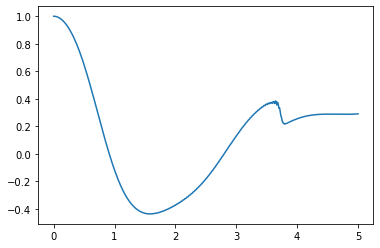

In [99]:
T = 2.5*2   # total time
N = 75*6     # Number of updates
dt = T/N       # time step
time  = np.arange(0,T+dt,dt)

chi = 20              # Bond dimension
d = 2                                  # Dimension of physical index

h_x, h_y, h_z = np.sqrt(3)/2 , np.log(2), 0.4  # Field in the different directions
J_xx, J_yy, J_zz = .5, .5, .5 # Strength of spin interactions

Model = [["xx"],["z","y"]]     # The first part of the model gives us the spin interaction and the second one the fields
Interactions_jit, Fields_jit = Model_coefficients_jaxed(J_xx,J_yy,J_zz,h_x,h_y,h_z)

# Initial Ferromagnet in Z direction

S_z_jax, S_x_jax, S_y_jax, S1_jax = Pauli_jaxed()

# Initial Ferromagnet in Z direction
Gamma_0 = np.zeros((chi,d,chi)).astype(complex)
Gamma_0[0,0,0]=1.+0j
Gamma_0/=LA.norm(Gamma_0)

Gamma_1=np.zeros((chi,d,chi)).astype(complex)
Gamma_1[0,0,0]=1.+0j
Gamma_1/=LA.norm(Gamma_1)

Gamma_jit=[Gamma_0,Gamma_1]

lama = np.zeros(chi)
lama[0] = 1.
lam_jit = [lama,lama]
# Hamiltonian
H_jit  = Create_HamiltonianTEBD(Model,S1_jax,Interactions_jit,Fields_jit,d)

# Time evolution operator
U = jax.scipy.linalg.expm(-1j*dt/2*H_jit.reshape(d**2,-1)).reshape(d,d,d,d)   # we devide dt by two because in ITEBD we perform two updates for a single step
# 2 site wave funciotn

Mz_iTEBD = iTEBD(lam_jit,Gamma_jit,U,S_z_jax)      # Main code
plt.plot(time,Mz_iTEBD.real)
plt.show()

# This is the part that uses only numpy, scipy etc.

In [100]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy
from functools import partial



def Pauli():
  S_z = np.diag([1.,-1.]).astype(np.complex128)
  S_x = np.array([[0.,1.],[1.,0.]],dtype = np.complex128)
  S_y = np.array([[0.,complex(0,-1.)],[complex(0,1.),0.]],dtype = np.complex128) #Pauli Matrices
  S1 = {
     "x" : S_x,
     "xx": S_x, 
     "y" : S_y,
     "yy": S_y, 
     "z" : S_z,
     "zz": S_z }
  return S_z, S_x, S_y, S1

def Model_coefficients(J_xx,J_yy,J_zz,h_x,h_y,h_z):
  Interactions = {
                  "xx":J_xx,
                  "yy":J_yy,
                  "zz":J_zz}
  Fields = {
          "x":h_x,  #Fields
          "y":h_y,
          "z":h_z}
  return Interactions,Fields


def Entropy_non_jit(v):
  return -np.sum(np.log(v, where = np.abs(v)>=1E-14)*v)

def Create_HamiltonianTEBD_non_jit(Model, S1, Interactions, Fields,d):
    H = np.zeros((d,d,d,d)).astype(np.complex128)

    for j in range(len(Model[0])):
      H += np.einsum("ij,kl->ikjl",2*Interactions[Model[0][j]]*S1[Model[0][j]],S1[Model[0][j]]) #two-site

    for k in range(len(Model[1])):
      H += np.einsum("ij,kl->ikjl",Fields[Model[1][k]]*S1[Model[1][k]],np.diag(np.ones(2)))    #on-site
      H += np.einsum("ij,kl->ikjl",np.diag(np.ones(2)),Fields[Model[1][k]]*S1[Model[1][k]])
    return H


def i_trunc_non_jit(chi,Fs,d=2):
  S,V,D = LA.svd(Fs,full_matrices=False)
    
  lam = V[:chi]/np.linalg.norm(V[:chi])

  A=S[:,:chi].reshape(chi,d,chi)
  B=D[:chi].reshape(chi,d,chi)
  
  return A,lam,B

def Compute_Theta_non_jit(lam_0,Gamma_0,lam_1,Gamma_1):
    Theta=np.einsum("a,aib->aib",lam_0,Gamma_0)
    Theta=np.einsum("aib,b->aib",Theta,lam_1)
    Theta=np.einsum("aib,bjc->aijc",Theta,Gamma_1)
    Theta=np.einsum("aijc,c->aijc",Theta,lam_0)

    return Theta

def apply_two_site_unitary_non_jit(lam_0,Gamma_0,lam_1,Gamma_1,U,chi,d):

    Theta = Compute_Theta_non_jit(lam_0,Gamma_0,lam_1,Gamma_1)
    Theta = np.einsum("ijkl,aijb->aklb",U,Theta)
    Theta=Theta.reshape(chi*d,chi*d)         

    Sigma,lam_1,Ve=i_trunc_non_jit(chi,Theta)

    vi=np.divide(1.0, lam_0, out=np.zeros_like(lam_0), where=np.abs(lam_0)>=1E-14)
    
    Gamma_1=np.einsum("aib,b->aib",Ve,vi)                            
    Gamma_0=np.einsum("a,aib->aib",vi,Sigma) 
    
    return Gamma_0,Gamma_1,lam_1


def Exp_value_two_site_non_jit(lam_0,Gamma_0,lam_1,Gamma_1,S_1,S_2):
   Theta = Compute_Theta_non_jit(lam_0,Gamma_0,lam_1,Gamma_1)
   
   Mz = np.einsum("ik,jm->ikjm",S_1 ,np.eye(2))
   Mz = np.einsum("aijb,ikjm->akmb",Theta,Mz)
   Mz1 = np.einsum("akmb,akmb->",Mz,np.conj(Theta))

   Mzz = np.einsum("ik,jm->ikjm",np.eye(2) ,S_2)
   Mzz = np.einsum("aijb,ikjm->akmb",Theta,Mzz)
   Mz2 = np.einsum("akmb,akmb->",Mzz,np.conj(Theta))
   return (Mz1+Mz2)/2

def iTEBD_non_jit(lam,Gamma,U,S_z) :
  T = 2.5*2   # total time
  N = 75*6 
  dt = T/N       # time step

  Mz_iTEBD_exp_two = np.zeros(N+1).astype(data_type)
  Mz_iTEBD_exp_two[0] = Exp_value_two_site_non_jit(lam[0],Gamma[0],lam[1],Gamma[1],S_z,S_z)

  Entropy_iTEBD = np.zeros(N+1).astype(data_type)
  Entropy_iTEBD[0] = Entropy_non_jit(lam[0])
  
  for ty in range(N):
   # Evolve the system imposing PBC
   Gamma[0],Gamma[1],lam[1] = apply_two_site_unitary_non_jit(lam[0],Gamma[0],lam[1],Gamma[1],U,chi,d)
   Gamma[1],Gamma[0],lam[0] = apply_two_site_unitary_non_jit(lam[1],Gamma[1],lam[0],Gamma[0],U,chi,d)
   
   # Calculate magnetization in the Z direction
   Mz_iTEBD_exp_two[ty+1] = Exp_value_two_site_non_jit(lam[0],Gamma[0],lam[1],Gamma[1],S_z,S_z)
   Entropy_iTEBD[ty+1]    = Entropy_non_jit(lam[0])
  return Mz_iTEBD_exp_two, Entropy_iTEBD

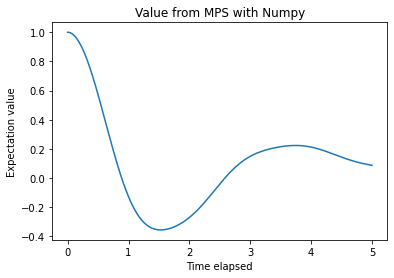

In [101]:
T = 2.5*2   # total time
N = 75*6      # Number of updates
dt = T/N       # time step

chi = 20              # Bond dimension
d = 2                                  # Dimension of physical index

h_x, h_y, h_z = np.sqrt(3)/2 , np.log(2), 0.4  # Field in the different directions
J_xx, J_yy, J_zz = .5, .5, .5  # Strength of spin interactions Multiply by 2 when comparing with quspib

Interactions, Fields = Model_coefficients(J_xx,J_yy,J_zz,h_x,h_y,h_z)
data_type=np.complex128
S_z, S_x, S_y, S1 = Pauli()

# Initial Ferromagnet in Z direction
Gamma_0 = np.zeros((chi,d,chi)).astype(complex)
Gamma_0[0,0,0]=1.+0j
Gamma_0/=LA.norm(Gamma_0)

Gamma_1=np.zeros((chi,d,chi)).astype(complex)
Gamma_1[0,0,0]=1.+0j
Gamma_1/=LA.norm(Gamma_1)

Gamma_non_jit=[Gamma_0,Gamma_1]

lama_non_jit = np.zeros(chi)
lama_non_jit[0] = 1.
lam_non_jit = [lama_non_jit,lama_non_jit]

# Hamiltonian
H_non_jit = Create_HamiltonianTEBD_non_jit(Model,S1,Interactions,Fields,d)

# Time evolution operator
U_non_jit = scipy.linalg.expm(-1j*dt/2*H_non_jit.reshape(d**2,-1)).reshape(d,d,d,d) # we devide dt by two because in ITEBD we perform two updates for a single step
# 2 site wave funciotn

Mz_iTEBD_exp_two,ent = iTEBD_non_jit(lam_non_jit,Gamma_non_jit,U_non_jit,S_z)          # Main code

#Plotting 
plt.plot(time,Mz_iTEBD_exp_two.real)

#plt.legend()
plt.xlabel("Time elapsed")
plt.ylabel("Expectation value")
plt.title("Value from MPS with Numpy")
plt.show()

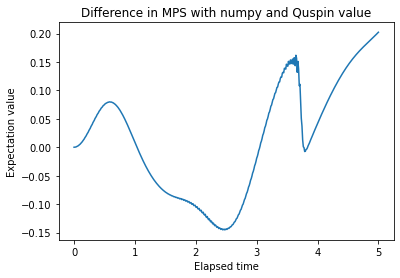

In [102]:
plt.plot(time,Mz_iTEBD.real - Mz_iTEBD_exp_two.real)
plt.xlabel("Elapsed time")
plt.ylabel("Expectation value")
plt.title("Difference in MPS with numpy and Quspin value")
plt.show()

# Quspin Comparison


In [103]:
from quspin.basis import spin_basis_general # Hilbert space spin basis
import quspin
from numpy import linalg as LA
from quspin.basis import spin_basis_1d 
from scipy.linalg import expm

L=12
basis=spin_basis_general(L,)
Ns = basis.Ns 
feromagnet=np.zeros(basis.Ns)
Name=''
for j in range(L):
      if j==0:
       Name+="1"
      else:
       Name+='1'
array_ind_s=basis.index(basis.state_to_int(Name))
feromagnet[array_ind_s]=1.0

Hermiticity check passed!
Hermiticity check passed!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian


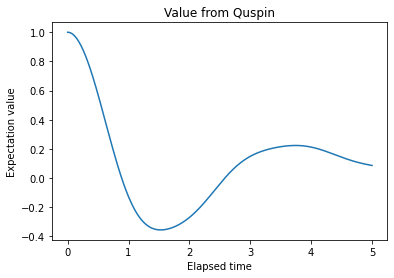

In [104]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.tools.evolution import expm_multiply_parallel # expm_multiply_parallel
#  Quspin evolution

T = 2.5*2  # total time
N = 75*6     # Number of updates
dt = T/N    # Number of updates
time  = np.arange(0,T+dt,dt)

np.random.seed(0)   # random seed
basis = spin_basis_1d(L,pauli=1,)     # Hilbert space                               

hx, hy, hz = np.sqrt(3)/2 , np.log(2), 0.4  # Field in the different directions
Jxx, Jyy, Jzz = .5, .5, .5 # Strength of spin interactions

periodic = True

if periodic:    
  J_xx  = [[Jxx,i,(i+1)%L] for i in range(L)] 
  J_yy  = [[Jyy,i,(i+1)%L] for i in range(L)] 
  J_zz  = [[Jzz,i,(i+1)%L] for i in range(L)] 
else:
  J_xx  = [[Jxx,i,i+1] for i in range(L-1)] 
  J_yy  = [[Jyy,i,i+1] for i in range(L-1)] 
  J_zz  = [[Jzz,i,i+1] for i in range(L-1)] 

Observable = [[1.,i] for i in range(L)]


h_x=[[hx,i] for i in range(L)]
h_z=[[hz,i] for i in range(L)]
h_y=[[hy,i] for i in range(L)]

static_H = [["xx",J_xx],["z",h_z],["y",h_y]] #HAMILTONIAN
static_O = [["z",Observable]]       # Observable
dynamic=[]


Fs=feromagnet.astype(complex)

H = hamiltonian(static_H,dynamic,basis=basis)   #HAMILTONIAN
O = hamiltonian(static_O,dynamic,basis=basis)   #OBSERVABLE

expectation_O = np.zeros(N+1,dtype=np.float64)
expectation_O[0] = O.expt_value(Fs).real

Entropy = np.zeros(N+1,dtype=np.float64)
Entropy[0] = quspin.tools.measurements.ent_entropy(Fs, basis)["Sent"]

exp_H = expm_multiply_parallel(H.tocsr(),a=-1j*dt)  #Time evolution operator
for d in range(N):
  exp_H.dot(Fs,overwrite_v=True)    #evolve
  expectation_O[d+1] = O.expt_value(Fs).real   #measure observable
  Entropy[d+1]= quspin.tools.measurements.ent_entropy(Fs, basis)["Sent"]
  
#Plotting

plt.plot(time,expectation_O/L)

#plt.legend()
plt.xlabel("Elapsed time")
plt.ylabel("Expectation value")
plt.title("Value from Quspin")
plt.show()

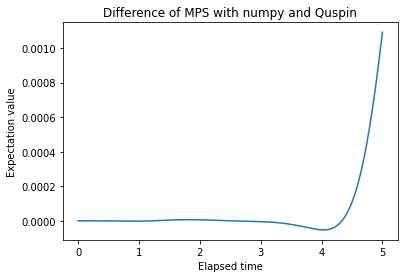

In [106]:
plt.plot(time,Mz_iTEBD_exp_two.real -expectation_O/L)

plt.xlabel("Elapsed time")
plt.ylabel("Expectation value")
plt.title("Difference of MPS with numpy and Quspin")
plt.show()